A notebook investigating Elo ratings systems, which are designed to provide numerical ratings for
players of a game such as chess, based on their win/loss match results.  The specific Elo system examined here is the one implemented by USA-Pickleball, but the results are universal to all basic Elo sytems.

Here, I'm looking at the effect of the value of the parameter "k" (which determines the maximum size of
the ratings bump that each
player gets due to winning / losing a match) on the precision of the ratings.  Generally, tuning the value of "k" is seen as a trade-off between being under-responsive and over-responsive.  I'm asking a more fundamental question: whether the choice of k affects the ability of the ratings system to be precise.

In an ideal, perfect scenario, how precise are the ratings, as a function of k?

I simulate matches bewteen players of equal skill (probability of winning a match = 0.5), and look at the ability of the ratings system to estimate their skill.  (They should all be rated as equal.)
Players begin the similation with either a uniform distribution of ratings in the range (4.0,5.0),
or a Gaussian distribution ~N(4.5,0.01). I demonstrate that the final ratings distributions are the same for the two starting condidtions, i.e the ratings system reaches an equilirium.

Findings: Larger k values do, in fact, reduce the precision of the rating's system's estimates.  For k in the range (0.05 -> 0.4), the ratings system reaches an equilibrium where players of equal strength have ratings with a standard deviation between 0.059 (for k = 0.05) and 0.315 (for k=0.4) ratings points.  Standard deviation increases linearly with k.

Practically: since the current USA-Pickleball ratings system uses k=0.1, the maximum possilbe precision that the ratings system can deliver in ideal conditions is a standard deviation of +/- 0.0928 ratings points, with 27% of players being mis-rated by 0.093 - 0.186 ratings points.


More details on Elo ratings systems at: https://en.wikipedia.org/wiki/Elo_rating_system, 
and also note that USA-Pickleball uses $ P = {1} / ( {1+20^{3(R_A-R_B)}} ) $ i.e. 
$ P = {1} / ( {1+10^{(\Delta R / 0.2562)}} ) $ instead of chess's 
$ P = {1} / ( {1+10^{(\Delta R / 400)}} ) $.


Comparing normalized "k" values is also intersting.  Chess sets k around 16-32 i.e. {16,32}/400 = {0.04,0.08}, whereas Pickleball uses k = 0.1, i.e. 0.1/0.2562 = 0.390.  Recall that in {Chess, Pickleball}, a ratings difference of {400,0.0256} means that the player rated higher is an estimated 10x as likely to win, i.e. p = 0.909.  Chess requires approximately 20 ratings bumps to advance, while pickleball requires only three.

(Briefly: an Elo system bumps a player's rating up or down after every match, with the size of the bump being proportional to the estimated probability of winning.  An upset leads to a larger bump, an expected result leads to a smaller bump.)

.  

.  
  

Tim Dellinger  
tim.dellinger@gmail.com  
Feb 2021

In [117]:
import random
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import normaltest
from scipy.stats import linregress

In [44]:
number_of_players = 10000

In [3]:
# we'll need this later to flatten lists

def flatten(a):
    return [item for sublist in a for item in sublist]

In [128]:
# play a single match, update ratings

def compete_and_update_ratings(a,b,k):
    #
    # takes two ratings and k as inputs, plays a match (coin flip), returns updated ratings as a tuple
    # note that a-b and b-a in the bump calculation are reversed depending on who wins
    #
    if (np.random.random() < 0.5):
        bump = k/(1+20**(3*(a-b)))
        return a + bump, b - bump
    else:
        bump = k/(1+20**(3*(b-a)))
        return a - bump, b + bump

In [130]:
# running this a few times verifies that the math is correct
# i.e. a small bump if the 5.0 team wins, a larger bump if the 4.5 team wins

for _ in range(6): 
    print (compete_and_update_ratings(5.0,4.5,0.1))

(4.901105672197775, 4.598894327802225)
(4.901105672197775, 4.598894327802225)
(4.901105672197775, 4.598894327802225)
(5.001105672197775, 4.498894327802225)
(5.001105672197775, 4.498894327802225)
(4.901105672197775, 4.598894327802225)


In [45]:
# create a list with player ratings
# the actual rating is arbitrary - let's choose 4.5 since that's a relevant pickleball rating
# add some jitter with random.normal()

players = list(np.random.normal(4.5,0.01) for _ in range(number_of_players))

In [7]:
# and a smaller list for use in testing our functions

players_short = list(np.random.normal(4.5,0.01) for _ in range(10))

In [8]:
#
# building up code to simulate playing matches
#

In [46]:
# this shuffles in place

random.shuffle(players)

In [11]:
# breaks the list into pairs, and feeds each pair through compete_and_update_ratings()
# this returns a list of pairs, which we'll have to flatten

list(compete_and_update_ratings(*players_short[i:i+2],0.1) for i in range(0, len(players_short), 2))


[(4.4443273076842225, 4.559296353214986),
 (4.544796115489873, 4.450098621977379),
 (4.455752457409915, 4.548250371366662),
 (4.538243635415902, 4.44176234107446),
 (4.548805075782857, 4.45159071437986)]

In [ ]:
# wrapping it up in a function

In [13]:
def play_matches(players_list,number_of_matches,k):
    for _ in range(number_of_matches):
        random.shuffle(players_list)
        players_list = flatten(list(compete_and_update_ratings(*players_list[i:i+2],k) for i in \
                           range(0, len(players_list), 2)))
    return players_list

In [14]:
# test the code on the short list to make sure it's running smoothly

play_matches(players_short,10,0.1)

[4.5627261461780515,
 4.456014986530498,
 4.4665581625994495,
 4.339895711517558,
 4.410216663888972,
 4.560117023350882,
 4.6084363508682324,
 4.5315143603608385,
 4.500133757454949,
 4.547309831046683]

mean 4.500143515286855 
 std 0.00996315720563632


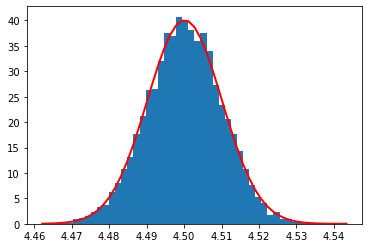

In [51]:
# let's have a look at our initial distribution

mu, std = norm.fit(players)
print("mean",mu,"\n", "std", std)

count,bins,_ = plt.hist(players, 50, density=True)
plt.plot(bins, norm.pdf(bins, mu, std),
         linewidth=2, color='r')
plt.show()

In [72]:
# might as well make that a funciton to save time

def make_plot(players_list):
    mu, std = norm.fit(players_list)
    print("mean",mu,"\n", "std", std)

    count,bins,_ = plt.hist(players_list, 50, density=True)
    plt.plot(bins, norm.pdf(bins, mu, std),
         linewidth=2, color='r')
    plt.show()

In [29]:
# run 50 matches with an absurdly high k=0.4

players_after_50 = play_matches(players,50,0.4)

mean 4.499980565571263 
 std 0.3132608456412646


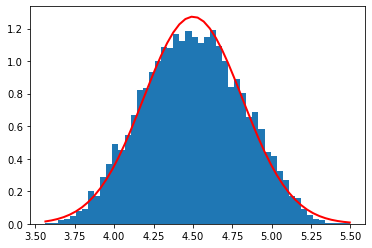

In [74]:
# the stdev is now 0.313 !!
# also: not looking quite like a gaussian

make_plot(players_after_50)

In [69]:
# D'Agostino & Pearson's test for normality, just for fun
#
# conclusion: not normal after 50 matches!

normaltest(players), normaltest(players_after_50)

(NormaltestResult(statistic=2.8280725471072974, pvalue=0.24315984013401606),
 NormaltestResult(statistic=158.580670267823, pvalue=3.669821858169645e-35))

In [38]:
# some rangefinding - 500 matches instead of 50 to see if the distribution evolves
# we can look more closely later at the number of matches required to reach equilibrium

players_after_500 = play_matches(players,500,0.4)

mean 4.499980565571263 
 std 0.3133724969782095


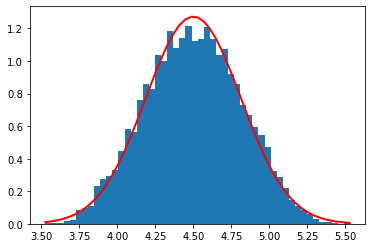

NormaltestResult(statistic=126.69699682535116, pvalue=3.076781832489054e-28)

In [85]:
# the stdev is still 0.313, so m50 was probably fine
# also: still not looking gaussian

make_plot(players_after_500)
normaltest(players_after_500)

In [79]:
# let's try starting with a uniform distribution instead

players_uniform = list(np.random.uniform(4.0,5.0) for _ in range(10000))

mean 4.500461042049678 
 std 0.2863740737119327


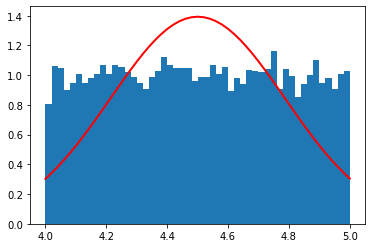

In [80]:
make_plot(players_uniform)

In [81]:
uniform_after_500 = play_matches(players_uniform,500,0.4)

mean 4.500461042049677 
 std 0.3146320432156508


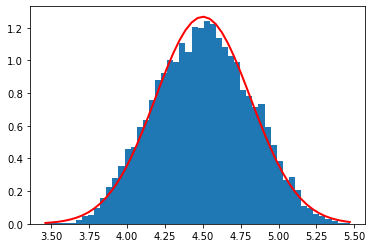

In [82]:
# the resulting distribution is quite similar (std = 0.315 vs 0.313 for the earlier runs)

make_plot(uniform_after_500)

In [83]:
# more rangefinding... 2000 mathces instead of 500

uniform_after_2000 = play_matches(players_uniform,2000,0.4)

mean 4.500461042049678 
 std 0.3144662516281215


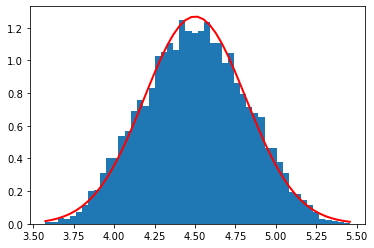

In [113]:
# result: not a lot of difference between 500 and 2000 matches

make_plot(uniform_after_2000)

In [ ]:
# I'll save investigation of "number of matches to reach equilibruim" for another day
# for now: std as a funciton of k

In [105]:
# round() will clean up the floating point messiness

k_list = list(a.round(decimals=4) for a in np.arange(0.05,0.41,0.05))
k_list

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [106]:
# recall that norm.fit()[1] is the stdev

# This'll only take a minute or so to run; no need to save intermediate results

stdev_list = list(norm.fit(play_matches(players_uniform,500,k))[1] for k in k_list)

In [107]:
stdev_list

[0.058933168652704086,
 0.09279667135368334,
 0.1270373097868587,
 0.16050220127606935,
 0.1977899617368219,
 0.2364227689911302,
 0.2774071749915212,
 0.31506494835369636]

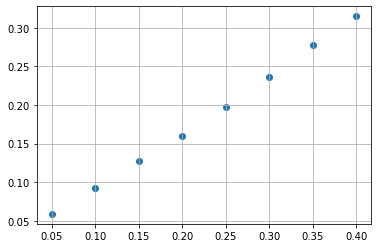

In [112]:
# looks linear-ish at first glance

plt.grid(True)
plt.scatter(k_list, stdev_list);

In [118]:
# yup, linear

linregress(k_list,stdev_list)

LinregressResult(slope=0.7336712176594529, intercept=0.018168251669433727, rvalue=0.9993406671161238, pvalue=7.162084405440105e-10, stderr=0.010881983518095663, intercept_stderr=0.0027475661570045473)

In [114]:
# lets run 2000 just to make sure we're getting good data for k=0.1 

final_sim = play_matches(players_uniform,2000,0.1)

mean 4.500461042049678 
 std 0.09288297583913226


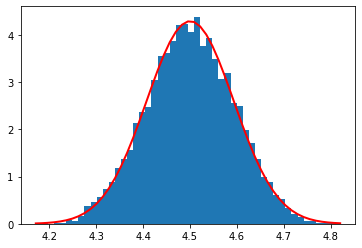

In [115]:
# stedev rounds to 0.0928 for both the 500 matches and the 2000, so I'll call that a match

make_plot(final_sim)

In [119]:
#  and we can also start with the players clustered around 4.5 instead of starting with
#  a uniform distribtuion

stdev_list_2 = list(norm.fit(play_matches(players,500,k))[1] for k in k_list)

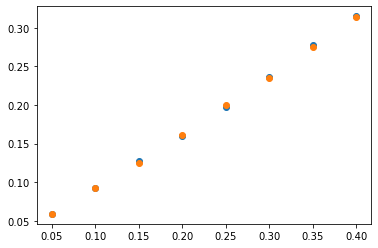

In [121]:
# they're falling right on top of each other!

plt.scatter(k_list, stdev_list)
plt.scatter(k_list, stdev_list_2)
plt.show()